In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
restaurant_dataframe = pd.read_csv('raw_data/nyc_restaurant_inspection_results.csv')
rodent_dataframe = pd.read_csv('raw_data/rodent_inspection.csv')

In [3]:
# get all restaurants that were inspected in 2021
restaurant_df = restaurant_dataframe.where(restaurant_dataframe['INSPECTION DATE'].str.contains(
    '2021', na=False) & (10001 <= restaurant_dataframe['ZIPCODE']) & (restaurant_dataframe['ZIPCODE'] <= 11697))
# removes rows with na score
restaurant_df = restaurant_df.dropna(how='any', subset=['SCORE'])

In [29]:
# Check if there are any restauratns that don't have a score. There aren't any (see output)
restaurant_df['SCORE'].isna().sum()

0

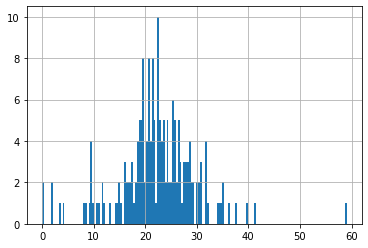

In [30]:
# see the distribution of the average restaurant scores grouped by zipcode where each column is a zipcode. It looks normal enough
restaurant_df.groupby('ZIPCODE')['SCORE'].mean().hist(bins=164)

In [4]:
# all reported rodent sightings in 2021, even if the inspection did not result in "Rat Activity"
rodent_df_all = rodent_dataframe[rodent_dataframe['INSPECTION_DATE'].str.contains('2021', na=False)]
# all reported rodent sightings in 2021 where the inspection resulted in "Rat Activity"
rodent_df_activity = rodent_dataframe[(rodent_dataframe['INSPECTION_DATE'].str.contains('2021', na=False)) & (rodent_dataframe['RESULT']=='Rat Activity')]

## Get descriptive statistics

In [5]:
restuarant_descriptive_stats = restaurant_df.groupby('ZIPCODE')['SCORE'].mean().describe()
rodent_all_descriptive_stats = rodent_df_all.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().describe()
rodent_activity_descriptive_stats = rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().describe()

### How many zipcodes don't overlap from each

In [6]:
extra_rodent_activity = set(rodent_df_activity.ZIP_CODE.unique()) - set(restaurant_df.ZIPCODE.unique())
extra_rodent_all = set(rodent_df_all.ZIP_CODE.unique()) - set(restaurant_df.ZIPCODE.unique())
extra_rest_act = set(restaurant_df.ZIPCODE.unique()) - set(rodent_df_activity.ZIP_CODE.unique())
extra_rest_all = set(restaurant_df.ZIPCODE.unique()) - set(rodent_df_all.ZIP_CODE.unique())

In [34]:
# Finding a unique key for the rows
rodent_df_all['JOB_TICKET_OR_WORK_ORDER_ID'].isna().sum()

0

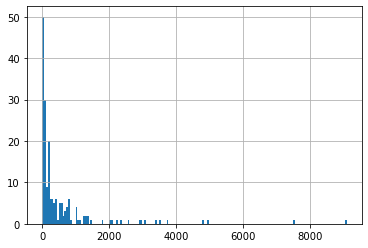

In [36]:
# rodent_df_all.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().hist(bins=164)

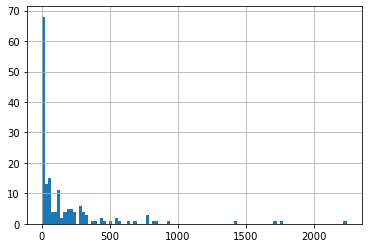

In [37]:
#rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().hist(bins=100)

### Combine the 2 datasets into 1 and run a linear regression

In [7]:
combined_data = pd.merge(
    left=rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().reset_index(name='count'),
    right=restaurant_df.groupby('ZIPCODE')['SCORE'].mean().reset_index(name='avg_score'),
    how="inner",
    on=None,
    left_on='ZIP_CODE',
    right_on='ZIPCODE',
    left_index=False,
    right_index=False,
    sort=True,
    validate="1:1")

In [6]:
combined_data.describe()

,ZIP_CODE,count,ZIPCODE,avg_score
count,164.000000,164.000000,164.000000,164.000000
mean,10803.939024,179.347561,10803.939024,23.468184
std,574.152688,323.718324,574.152688,6.363188
min,10001.000000,1.000000,10001.000000,0.000000
25%,10296.250000,11.000000,10296.250000,19.912068
50%,11153.500000,50.500000,11153.500000,22.628838
75%,11357.250000,210.500000,11357.250000,26.403549
max,11694.000000,2241.000000,11694.000000,59.033333


In [10]:
X = combined_data[['count']]
Y = combined_data.avg_score

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y,X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.003754
Date:                Thu, 21 Apr 2022   Prob (F-statistic):              0.951
Time:                        13:34:41   Log-Likelihood:                -535.69
No. Observations:                 164   AIC:                             1075.
Df Residuals:                     162   BIC:                             1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4512      0.570     41.128      0.0

/usr/lib/python3/dist-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Let's try to transform the rodent data to make it a little more normal

In [11]:
combined_data_copy = combined_data.copy()
combined_data_copy['log_count'] = np.log(combined_data_copy['count'])

In [12]:
X = combined_data_copy.log_count
Y = combined_data_copy.avg_score

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y,X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.990
Date:                Thu, 21 Apr 2022   Prob (F-statistic):             0.0857
Time:                        13:35:00   Log-Likelihood:                -534.19
No. Observations:                 164   AIC:                             1072.
Df Residuals:                     162   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6711      1.151     18.833      0.0

/usr/lib/python3/dist-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


#### Workspace

In [13]:
moore_lm = ols('avg_score ~ log_count', data=combined_data_copy).fit()

In [20]:
table = sm.stats.anova_lm(moore_lm, type=1)
print(table)

              df       sum_sq     mean_sq        F    PR(>F)
log_count    1.0   119.597090  119.597090  2.98979  0.085696
Residual   162.0  6480.298251   40.001841      NaN       NaN


In [15]:
moore_lm = ols('avg_score ~ count', data=combined_data).fit()

In [16]:
table = sm.stats.anova_lm(moore_lm, type=1)
print(table)

             df       sum_sq    mean_sq         F    PR(>F)
count       1.0     0.152919   0.152919  0.003754  0.951222
Residual  162.0  6599.742421  40.739151       NaN       NaN


In [42]:
#combined_data_copy.to_csv('text.csv')

### Let's try to normalize the data

In [22]:
from sklearn import preprocessing

In [23]:
standardized_count = preprocessing.normalize([combined_data['count']])
standardized_score = preprocessing.normalize([combined_data['avg_score']])

In [24]:
X = standardized_count[0]
Y = standardized_score[0]

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y,X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                  0.003754
Date:                Wed, 20 Apr 2022   Prob (F-statistic):              0.951
Time:                        23:25:02   Log-Likelihood:                 405.81
No. Observations:                 164   AIC:                            -807.6
Df Residuals:                     162   BIC:                            -801.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0753      0.002     41.128      0.0